In [1]:
import jax
num_devices = jax.local_device_count()
print(f'# of GPUs : {num_devices}')

import haiku as hk
import optax
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
from functools import partial
from itertools import product

# we import some helper function/classes
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from models.resnet import ResNet, Block
from datasets.cifar import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# of GPUs : 8


/usr/local/lib/python3.8/dist-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
NUM_CLASSES = 100
NUM_EPOCH = 200
NUM_TRAIN = 50000
BATCH_SIZE = 1000
WARMUP_RATIO = 0.1
PEAK_LR = 0.4

rng = jax.random.PRNGKey(42)
batch = jnp.zeros((1, 32, 32, 3), jnp.float32)
net = partial(
    ResNet,
    name='ResNet_18',
    stage_sizes=[2, 2, 2, 2],
    num_filters=[64, 128, 256, 512],
    strides=[1, 2, 2, 2],
    block_cls=Block,
    num_classes=NUM_CLASSES,
)

net = make_forward_with_state(net)
params, state = net.init(rng, batch, train=True, print_shape=True)

tx = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.sgd(learning_rate=create_lr_sched(NUM_EPOCH, NUM_TRAIN, BATCH_SIZE, WARMUP_RATIO, PEAK_LR), momentum=0.9)
    )
trainer = Trainer.create(
    apply_fn=net.apply,
    params=params,
    state=state,
    tx=tx,
)

input : (1, 32, 32, 3)
embedding : (1, 32, 32, 64)
block_0_0 : (1, 32, 32, 64)
block_0_1 : (1, 32, 32, 64)
block_1_0 : (1, 16, 16, 128)
block_1_1 : (1, 16, 16, 128)
block_2_0 : (1, 8, 8, 256)
block_2_1 : (1, 8, 8, 256)
block_3_0 : (1, 4, 4, 512)
block_3_1 : (1, 4, 4, 512)
representation : (1, 512)
classifier head : (1, 100)


In [3]:
trainer = load_ckpt('../3_image_classification/result/cifar100/renset_18', trainer)

batch_dims = (num_devices, BATCH_SIZE//num_devices)
train_dataset = list(load_dataset(NUM_CLASSES, batch_dims, True, False, False))
test_dataset = list(load_dataset(NUM_CLASSES, batch_dims, False, False, False))

test_acc = compute_acc_dataset(replicate(trainer), test_dataset)
print(f'Recovered Test Accuracy : {test_acc:.4f}')

Recovered Test Accuracy : 0.7883


In [4]:
# Modified Lanczos alogrithm of https://github.com/google/spectral-density/blob/master/jax/lanczos.py for recent JAX ver.

@jax.pmap
def hvp_batch(v, trainer, batch):
    vec_params, unravel_fn = params_to_vec(trainer.params, True)
        
    def loss(params):
        logit, state = trainer.apply_fn(params, trainer.state, None, batch['x'], train=True)
        log_prob = jax.nn.log_softmax(logit)
        return - (log_prob * batch['y']).sum(axis=-1).mean()
    
    gvp, hvp = jax.jvp(jax.grad(loss), [trainer.params], [unravel_fn(v)])
    return params_to_vec(hvp)

def hvp(v, trainer, dataset):
    res = 0.
    for batch in dataset:
        res += hvp_batch(replicate(v), trainer, batch).sum(axis=0)
    res = res / len(dataset)
    return res

def lanczos(trainer, dataset, rand_proj_dim=10, seed=42):
    
    rng = jax.random.PRNGKey(seed)
    vec_params, unravel_fn = params_to_vec(unreplicate(trainer).params, True)
    
    tridiag = jnp.zeros((rand_proj_dim, rand_proj_dim))
    vecs = jnp.zeros((rand_proj_dim, len(vec_params)))
    
    init_vec = jax.random.normal(rng, shape=vec_params.shape)
    init_vec = init_vec / jnp.linalg.norm(init_vec)
    vecs = vecs.at[0].set(init_vec)
    
    beta = 0
    for i in tqdm(range(rand_proj_dim)):
        v = vecs[i, :]
        if i == 0:
            v_old = 0
        else:
            v_old = vecs[i -1, :]
        
        w = hvp(v, trainer, dataset)
        w = w - beta * v_old
        
        alpha = jnp.dot(w, v)
        tridiag = tridiag.at[i, i].set(alpha)
        w = w - alpha * v
        
        for j in range(i):
            tau = vecs[j, :]
            coef = np.dot(w, tau)
            w += - coef * tau
            
        beta = jnp.linalg.norm(w)
        
        if (i + 1) < rand_proj_dim:
            tridiag = tridiag.at[i, i+1].set(beta)
            tridiag = tridiag.at[i+1, i].set(beta)
            vecs = vecs.at[i+1].set(w/beta)
            
    return tridiag, vecs

In [5]:
tridiag, vecs = lanczos(replicate(trainer), train_dataset, 100)

  0%|          | 0/100 [00:00<?, ?it/s]2022-10-12 17:40:10.341090: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[3,3,64,128]{1,0,2,3}, u8[0]{0}) custom-call(f32[125,32,32,64]{2,1,3,0}, f32[125,32,32,128]{2,1,3,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_01io->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-10-12 17:40:10.479174: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[3,3,64,64]{1,0,2,3}, u8[0]{0}) custom-call(f32[125,32,32,64]{2,1,3,0}, f32[125,32,32,64]{2,1,3,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_01io->b01f, custom_call_target="__cudnn$convBackwardFilter", bac

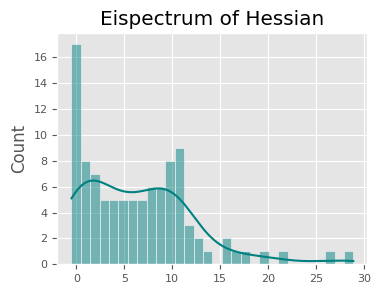

In [8]:
eigval, eigvec = np.linalg.eigh(tridiag)
eigval = np.sort(eigval)
sns.histplot(eigval, color='teal', bins=30, kde=True)
plt.title('Eispectrum of Hessian')
plt.show()